# Blackout gap detection example notebook
This notebook shows
1. the usage of a blackout gap detection on a dataset of 500 CMLs and a 10 day period
2. two example CMLs with which have a very high and a very low number of blackout gaps

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pycomlink as pycml
import xarray as xr
from tqdm import tqdm
import urllib.request
import io
import pycomlink.processing.blackout_gap_detection as blackout_detection

# Do show xarray.Dataset representation as text because gitlab/github
# do not (yet) render the html output correctly (or sometimes not at all...)
xr.set_options(display_style="text");

In [2]:
# get data from 500 CMLs and eleven days
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + "/example_cml_data.nc")

In [3]:
# get recieved signal levels values without default fill values (-99 and -99.9)
rsl = cmls.rsl.where(cmls.rsl > -99).isel(channel_id=0)

In [4]:
gap_start_list = []
gap_end_list = []
gap_mask_list = []

for cml_id in tqdm(rsl.cml_id):
    rsl_i = rsl.sel(cml_id=cml_id)

    gap_start, gap_end = blackout_detection.get_blackout_start_and_end(
        rsl=rsl_i.values, rsl_threshold=-65
    )

    mask = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl_i.values, gap_start, gap_end
    )

    mask_reverse = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl_i.values[::-1], gap_end[::-1], gap_start[::-1]
    )

    mask = mask | mask_reverse[::-1]

    gap_start_list.append(gap_start)
    gap_end_list.append(gap_end)
    gap_mask_list.append(mask)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<03:36,  2.31it/s]

 14%|█▎        | 68/500 [00:00<00:02, 167.76it/s]

 25%|██▍       | 123/500 [00:00<00:01, 266.96it/s]

 37%|███▋      | 186/500 [00:00<00:00, 363.87it/s]

 50%|█████     | 252/500 [00:00<00:00, 444.98it/s]

 64%|██████▍   | 321/500 [00:00<00:00, 513.01it/s]

 78%|███████▊  | 390/500 [00:01<00:00, 562.77it/s]

 91%|█████████ | 455/500 [00:01<00:00, 586.76it/s]

100%|██████████| 500/500 [00:01<00:00, 410.44it/s]

In [5]:
rsl = rsl.to_dataset()
rsl["gap_start"] = (["cml_id", "time"], gap_start_list)
rsl["gap_list"] = (["cml_id", "time"], gap_end_list)
rsl["mask"] = (["cml_id", "time"], gap_mask_list)

In [6]:
# get the three CMLs with the most blackout minutes
rsl_blackouts = rsl.isel(cml_id=(np.array(gap_mask_list).sum(axis=1) > 35))
rsl_blackouts

<pre>&lt;xarray.Dataset&gt;
Dimensions:           (time: 15840, cml_id: 3)
Coordinates:
  * time              (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id            (cml_id) object &#x27;MY0493_2_MY2121_3&#x27; ... &#x27;MY2121_2_MY211...
    length            (cml_id) float64 16.19 8.559 15.24
    site_a_latitude   (cml_id) float64 56.99 57.06 57.13
    site_a_longitude  (cml_id) float64 3.215 3.312 3.282
    site_b_latitude   (cml_id) float64 57.13 57.13 57.12
    site_b_longitude  (cml_id) float64 3.282 3.282 3.489
    channel_id        &lt;U9 &#x27;channel_1&#x27;
    frequency         (cml_id) float64 1.92e+10 2.309e+10 1.82e+10
    polarization      (cml_id) object &#x27;V&#x27; &#x27;V&#x27; &#x27;V&#x27;
Data variables:
    rsl               (cml_id, time) float32 -48.9 -48.5 -48.9 ... -47.6 -47.9
    gap_start         (cml_id, time) bool False False False ... False False
    gap_list          (cml_id, time) bool False False False ... False False
    mask              (cml_id, time) bool False False False ... False False</pre>

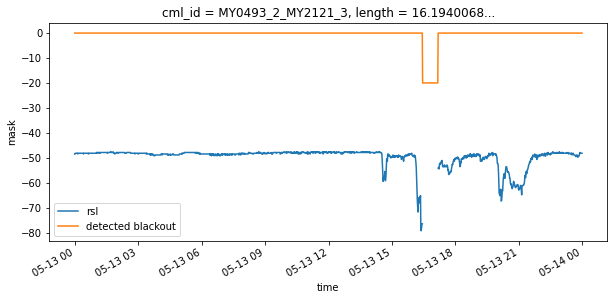

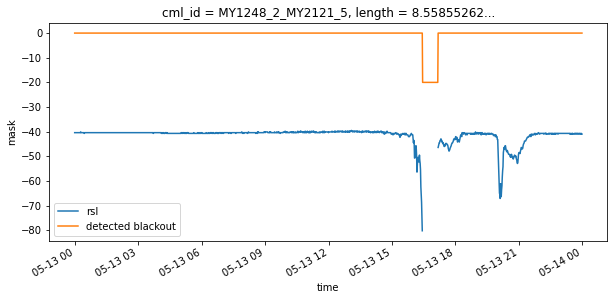

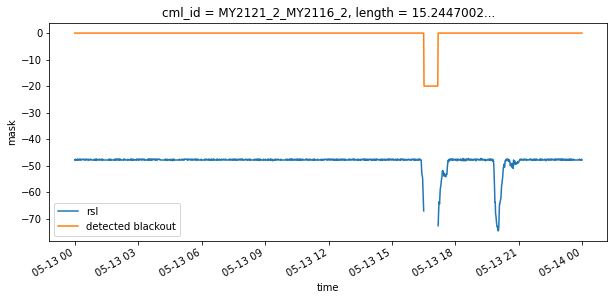

In [7]:
for cml_id in rsl_blackouts.cml_id:
    rsl_blackouts.rsl.sel(cml_id=cml_id, time="2018-05-13").plot(
        figsize=(10, 4), label="rsl"
    )
    (rsl_blackouts.mask.sel(cml_id=cml_id, time="2018-05-13") * -20).plot(
        label="detected blackout"
    )
    plt.legend()

In [8]:
# loading CML example data from zenodo
url_cml_data='https://zenodo.org/record/6337557/files/blackout_example_cmls.nc' 
req_cml_data = urllib.request.Request(url_cml_data)
with urllib.request.urlopen(req_cml_data) as resp:
    cmls = xr.open_dataset(io.BytesIO(resp.read()))
    
# loading reference data from zenodo    
url_ref_data='https://zenodo.org/record/6337557/files/blackout_example_radar_reference.nc' 
req_ref_data = urllib.request.Request(url_ref_data)
with urllib.request.urlopen(req_ref_data) as resp:
    reference = xr.open_dataset(io.BytesIO(resp.read()))

#### Two CMLs with three years of data. For one 15 minutes for the other 200 minutes of blackouts are detected

In [9]:
# remove default rsl values
cmls["rsl"] = cmls.rsl.where(cmls.rsl > -99).isel(channel_id=0)
cmls["tsl"] = cmls.tsl.where(cmls.rsl > -99).isel(channel_id=0)

In [10]:
# define a plotting function
def plt_ts(rsl, tsl, ref, mask, start, x_ax=True, legendfonstsize=10, ax=None):

    if ax is None:
        fig, ax = plt.subplots()

    ay = ax.twinx()
    ay.bar(np.arange(len(ref)), ref * 60, color="#045a8d", alpha=0.6)
    ay.set_ylim(-10, 180)
    ay.set_yticks([0, 50, 100, 150])
    ay.set_ylabel("rainfall intensity \n[mm/h]", color="#045a8d")

    rsl[rsl < -99] = np.nan
    ax.plot(tsl, color="#238b45", label="transmitted \nsignal level", lw=2)
    ax.plot(rsl, color="#cc4c02", label="recieved \nsignal level", lw=2)

    ax.plot((mask * -5) + 33.5, lw=4, color="black")
    ax.plot((mask + 100), color="black", lw=3, label="detected \nblackout gap")

    ax.set_ylim(-92, 30)
    ax.set_title("")

    if x_ax == True:
        ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240])
        ax.set_xlabel("time [minutes]")
        ax.legend(
            loc="center left", ncol=3, prop={"size": legendfonstsize}, frameon=False
        )
    if x_ax == False:
        ax.set_xticks([])
        ax.set_xlabel("")

    ax.set_title(str(start.values)[0:10] + " " + str(start.values)[11:16])

    ax.set_yticks([20, 0, -20, -40, -60, -80])
    ax.set_ylabel("signal level\n[dBm]")
    plt.show()

For CML with the id DO2315_2_DO2314_2 there are 15 detected blackout minutes.
Plotting all detected gaps:


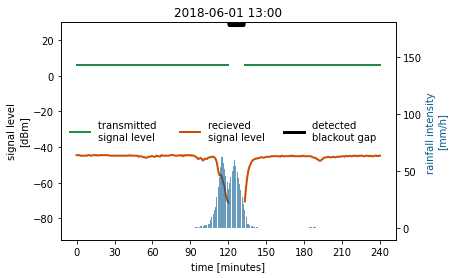

#################################################

For CML with the id NY1283_2_NY1294_3 there are 200 detected blackout minutes.
Plotting all detected gaps:


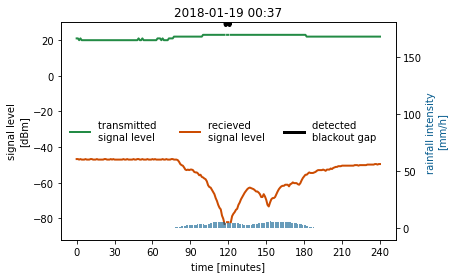

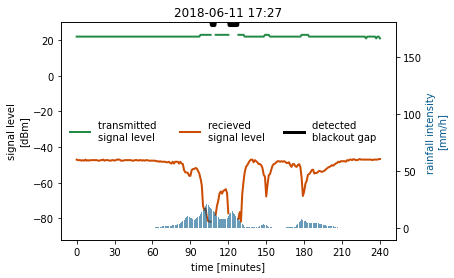

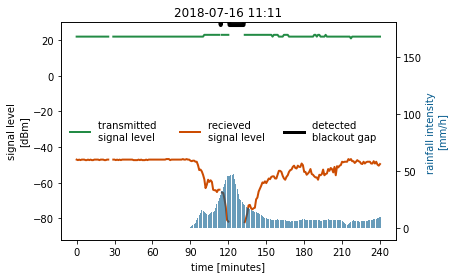

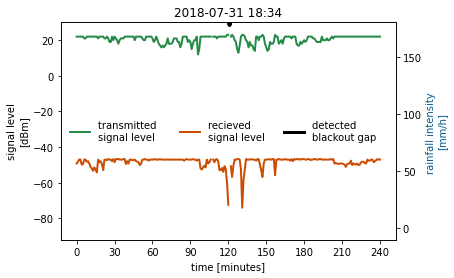

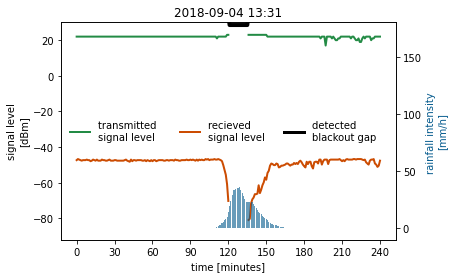

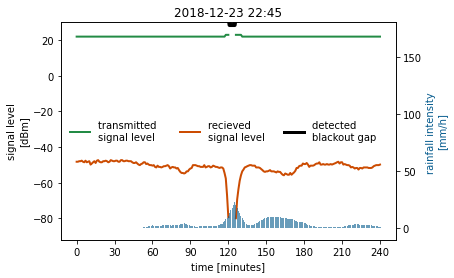

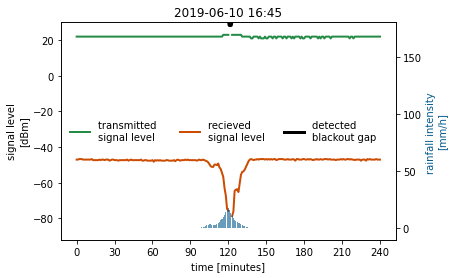

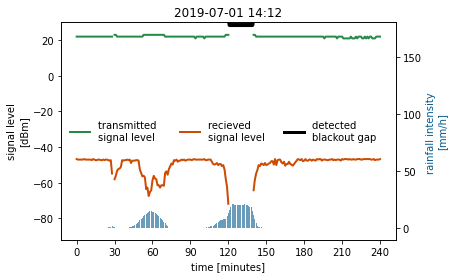

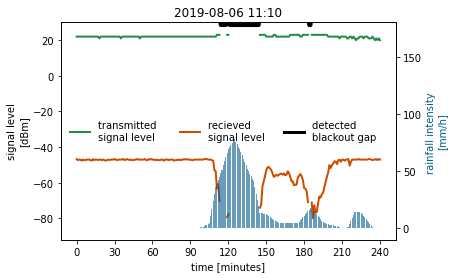

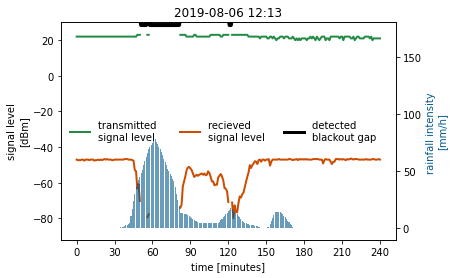

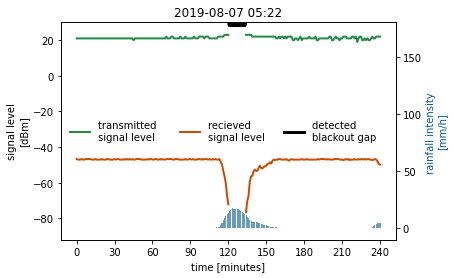

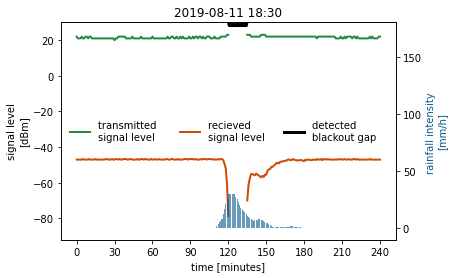

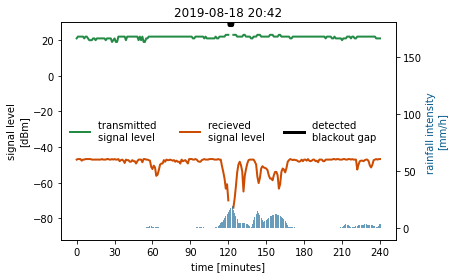

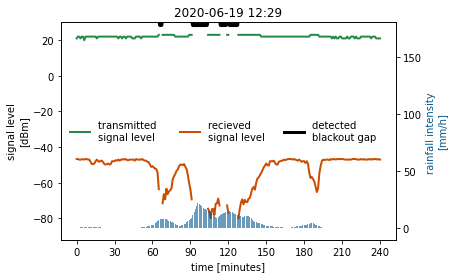

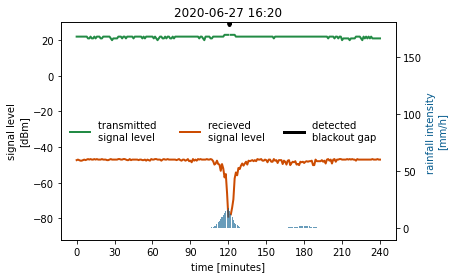

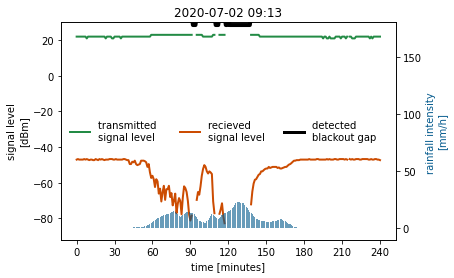

#################################################



In [12]:
for cml_id in cmls.cml_id:
    rsl = cmls.sel(cml_id=cml_id).rsl
    tsl = cmls.sel(cml_id=cml_id).tsl
    ref = reference.sel(cml_id=cml_id)
    
    gap_start, gap_end = blackout_detection.get_blackout_start_and_end(
        rsl=rsl.values, rsl_threshold=-65
    )

    mask = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl.values, gap_start, gap_end
    )

    mask_reverse = blackout_detection.created_blackout_gap_mask_from_start_end_markers(
        rsl.values[::-1], gap_end[::-1], gap_start[::-1]
    )

    mask = mask | mask_reverse[::-1]

    rsl = rsl.to_dataset()
    rsl["mask"] = ("time", mask)
    print(
        "For CML with the id "
        + str(cml_id.values)
        + " there are "
        + str(mask.sum())
        + " detected blackout minutes."
    )
    print("Plotting all detected gaps:")

    # remove gap_start times which are less than 60 minutes after another gap_start
    very_close_gaps = (
        np.diff(rsl.sel(time=gap_start).time.values) / 60000000000
    ).astype(int) < 60
    gap_time = rsl.sel(time=gap_start).time[~np.append(very_close_gaps, np.array(True))]

    # plot each gap
    for gap_start_time in gap_time:
        start = gap_start_time - np.timedelta64(2, "h")
        end = gap_start_time + np.timedelta64(2, "h")
        plt_ts(
            rsl=rsl.rsl.sel(time=slice(start, end)),
            tsl=tsl.sel(time=slice(start, end)),
            ref=ref.rainfall_amount.sel(time=slice(start, end)),
            mask=rsl.mask.sel(time=slice(start, end)),
            start=start,
            x_ax=True,
        )
    print("#################################################\n")